# Lightweight Fine-Tuning of GPT2 for Medical Text Classification

## **Content**

### 1. [Project Description]((#section_1))
### 2. [Install and import required libraries](#section_2)
### 3. [Define Hyperparameters and Directories](#section_3)
### 4. [Load and Preprocess Dataset using Hugging Face Tokenizer](#section_4)
### 5. [Train and Test Split](#section_5)
### 6. [Create Data Loader](#section_6)
### 7. [Loading and Evaluating a Foundation Model](#section_7)
### 8. [Performing Parameter-Efficient Fine-Tuning](#section_8)
### 9. [Load and Performe Inference with a PEFT Model](#section_9)
### 10. [Evaluate PEFT Model Pefrormance](#section_10)
### 11. [Summary](#section_11)

## <a name="section_1"></a>**1. Project Description**


This project is on **Parameter Efficient Fine-Tuning (PEFT)** of foundation models to improve the performance of the model to classify medical health advice. The idea is given a sequence or text, classify the sequence whether it is not advice, weak advice or strong adice. The problem was framed as a sequence classification. The `medalpaca/medical_meadow_health_advice`([link](https://huggingface.co/datasets/medalpaca/medical_meadow_health_advice)) dataset in Hugging face was used to fine-tune the model and evaluate its performance performance.

* **Model:** GPT2 model was due to its small number of parameters, so that it will be easy to fine-tune it in smaller GPU memory available from Udacity workspace.
* **Fine-tuning dataset:** As described above the `medalpaca/medical_meadow_health_advice` dataset in Hugging face was used to fine-tune and evaluate the performance of the model. The dataset was split into training (60%) and test set (30%).

* **PEFT technique:** Low-Rank Adaptation (LoRA) in Hugging face was used to fine-tune the model on the task since it has reduced computational and memory requirements.

* **Evaluation approach:** both of the Foundation Model and the PEFT Model were evaluated on a separately held test data using accuracy and f1-score metrics. Confusion matrix was also plotted. Model performance is evaluated as follows:
    * Classification accuracy
    * Classification F1-score
    * Classification confusion matrix
    * Mis-classified sequences have been also explored



## <a name="section_2"></a>**2. Install and Import Required Libraries**

In [15]:
!pip install -q datasets transformers torch pandas numpy peft scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
import os
from datasets import load_dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import LoraConfig, get_peft_model, get_peft_config, PeftModel, PeftConfig, AutoPeftModelForSequenceClassification
import torch
import pandas as pd
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np



## <a name="section_3"></a>**3. Define Hyperparameters and Directories**


In [17]:
# The name of dataset to use
dataset_name = "medalpaca/medical_meadow_health_advice"

# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = "gpt2" # "google-bert/bert-base-cased" # "gpt2"

# Number of classes in the dataset
num_labels = 3

# The dataset contains only training samples and test dataset need to be sampled
# This is the percentage of the test data; for reproducibility, random state was set during sampling
test_size = 0.3

# Number of training epochs.
epochs = 10

# Number of batches - depending on the max sequence length and GPU memory.
batch_size = 3

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"You are using {device} device")

output_dir = "results_exp_2"


You are using cuda device


In [18]:
#If gpu is available display device property
if torch.cuda.is_available():
    print(f"Available number of GPUs: {torch.cuda.device_count()}")
    print(f"Available device name: {torch.cuda.get_device_name()}")
    print(f"Available GPUs properties: {[torch.cuda.get_device_properties(i) for i in range(torch.cuda.device_count())]}")

Available number of GPUs: 1
Available device name: Tesla T4
Available GPUs properties: [_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=14917MB, multi_processor_count=40)]


In [19]:
#Make output director if it doesnot exist
os.makedirs(output_dir, exist_ok=True)

## <a name="section_4"></a>**4. Load and Preprocess Dataset using Hugging Face Tokenizer**


In [20]:
dataset = load_dataset(dataset_name)
dataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'output', 'input'],
        num_rows: 8676
    })
})

In [21]:
# The dataset has only train set and take out the training set
dataset = dataset['train']
print(f"Displaying the the first element of the dataset --> \n{dataset[0]}")

Displaying the the first element of the dataset --> 
{'instruction': 'Question: is this a 2) strong advice, 1) weak advice 0) no advice?', 'output': 'This is no advice', 'input': 'As we have previously shown an additional effect of vibrating insoles on improving static balance [3–5], it is possible that the combined effect on balance and gait will have a greater impact on falls and mobility than our data would imply. '}


### Load Tokenizer from Hugging Face

In [22]:
def get_tokenizer():
    """
    Load and configure a tokenizer for a pretrained model.

    This function loads a tokenizer from a pretrained model specified by `model_name_or_path`, 
    sets the padding side to the left, and assigns the end-of-sequence (EOS) token as the padding token.

    Returns:
        AutoTokenizer: A configured tokenizer instance.
    """
    # Loading the tokenizer from the pretrained model
    print("Loading tokenizer model...")
    tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)

    # Set the tokenizer to pad sequences on the left side (i.e., padding is applied before the sequence).
    tokenizer.padding_side = "left"

    # Set the PAD token to be the same as the EOS token. EOS token typically has the ID 50256.
    tokenizer.pad_token = tokenizer.eos_token
    
    return tokenizer


### Pre-process Dataset

In [23]:
# Display sample dataset
dataset[0]

{'instruction': 'Question: is this a 2) strong advice, 1) weak advice 0) no advice?',
 'output': 'This is no advice',
 'input': 'As we have previously shown an additional effect of vibrating insoles on improving static balance [3–5], it is possible that the combined effect on balance and gait will have a greater impact on falls and mobility than our data would imply. '}

In [24]:
# Get class names or labels in the dataset
label_names = list(set(dataset['output']))
print(f"There are {len(label_names)} classes and the class names are:{label_names}")

There are 3 classes and the class names are:['This is a strong advice', 'This is a weak advice', 'This is no advice']


In [25]:
# Class names
label_names = ['This is no advice', 'This is a weak advice', 'This is a strong advice']

In [26]:
# Get label to int id and int id to label mapping dictionaries
id2label = dict()
label2id = dict()
for id_, label_name in enumerate(label_names):
    label2id[label_name] = id_
    id2label[id_] = label_name
    
# Get the id mapping of eacha label
dataset = dataset.map(lambda batch_in: {'labels':[label2id[output] for output in batch_in['output']]}, batched=True)

In [27]:
tokenizer = get_tokenizer()
def tokenizer_func(examples):
    """
    Tokenizes a batch of input sequences, ensuring uniform encoding length through truncation and padding.

    Args:
        examples (dict): A dictionary containing input sequences under the key 'input'.

    Returns:
        dict: A dictionary containing tokenized sequences, padded to the maximum length in the batch and truncated as needed.
    """
    # Tokenize the input sequences in the batch, ensuring each sequence has the same length.
    # The sequences are truncated if they exceed the maximum length allowed by the tokenizer.
    # Padding is applied to make all sequences in the batch the same length.
    # The tokenized output is returned as PyTorch tensors ('pt').
    return tokenizer(examples['input'], padding='max_length', truncation=True, return_tensors='pt')


Loading tokenizer model...


In [28]:
print(f"Tokenizing dataset ...")
# batch based tokenisation of text using Map (More information can be found here, https://huggingface.co/docs/datasets/en/process) 
tokenized_dataset = dataset.map(tokenizer_func, batched=True)
tokenized_dataset

Tokenizing dataset ...


Map:   0%|          | 0/8676 [00:00<?, ? examples/s]

Dataset({
    features: ['instruction', 'output', 'input', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 8676
})

In [29]:
# Remove unwanted columns from the datasets
# print("Selecting columns for model input ....")
# tokenized_dataset = tokenized_dataset.select_columns(['labels', 'input_ids', 'attention_mask'])


## <a name="section_5"></a>**5. Train and Test Split**

In [30]:
# Creating training and test data loaders
print('Creating training and test split ...')
## Set the format of the dataset to return PyTorch tensors instead of lists:
tokenized_dataset.set_format('torch')
split = tokenized_dataset.train_test_split(test_size=test_size, shuffle=True, seed=2024)
train = split['train']
test = split['test']
test

Creating training and test split ...


Dataset({
    features: ['instruction', 'output', 'input', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 2603
})

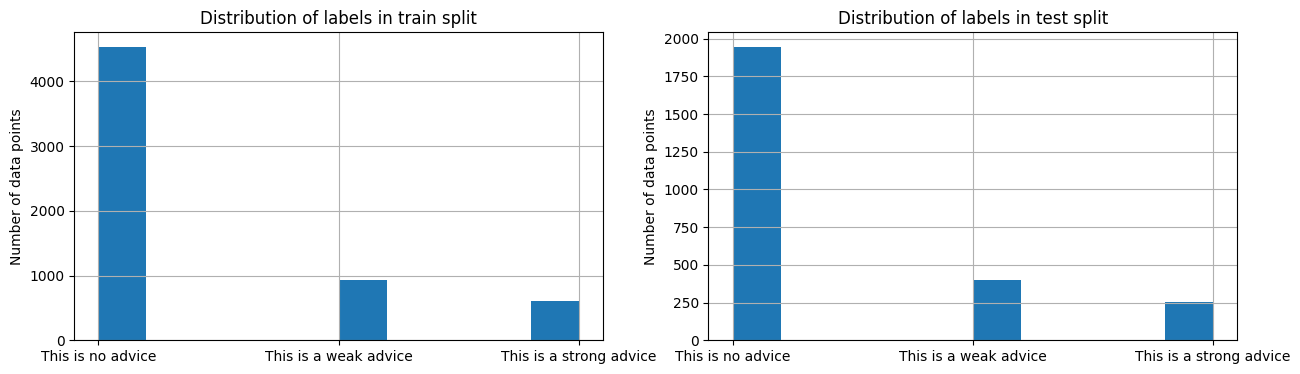

In [31]:
# Create figure to plot distribution of the classes in 
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
pd.Series(train['output'], name="Label").hist(ax=axs[0])
pd.Series(test['output'], name="Label").hist(ax=axs[1])
for ax, split in zip(axs, ['train', 'test']):
    ax.set_title(f"Distribution of labels in {split} split")
    ax.set_ylabel('Number of data points')
plt.savefig(os.path.join(output_dir, 'class_distribution.png'))

There is class imbalace between the classes and when applying PEFT, **class weight will applied while fine-tuning foundation model**.

## <a name="section_6"></a>**6. Create Data Loader**


In [32]:
# Move dataset to DataLoader
train_dataloader = DataLoader(train.select_columns(['labels', 'input_ids', 'attention_mask']), 
                              shuffle=True, 
                              batch_size=batch_size)
print(f"created training Data Loader with {len(train_dataloader)} batches")
test_dataloader = DataLoader(test.select_columns(['labels', 'input_ids', 'attention_mask']), 
                             batch_size=batch_size)
print(f"created test Data Loader with {len(test_dataloader)} batches")

created training Data Loader with 2025 batches
created test Data Loader with 868 batches


## <a name="section_7"></a>**7. Loading and Evaluating a Foundation Model**


In [33]:
def get_fm_model(tokenizer):
    """
    Load and configure a pretrained language model for sequence classification.

    This function loads a large language model (LLM) for sequence classification, 
    adjusts its embedding layer to match the tokenizer's vocabulary size, 
    and sets the padding token ID to be the same as the end-of-sequence (EOS) token ID.

    Args:
        tokenizer (AutoTokenizer): The tokenizer used with the model, which determines the vocabulary size.

    Returns:
        AutoModelForSequenceClassification: A configured model instance ready for sequence classification tasks.
    """
    # Load the pretrained language model for sequence classification
    print("Loading LLM model..")
    model = AutoModelForSequenceClassification.from_pretrained(
        pretrained_model_name_or_path=model_name_or_path,
        num_labels=num_labels)

    # Adjust the model's embedding layer to accommodate any new tokens added to the tokenizer
    model.resize_token_embeddings(len(tokenizer))

    # Set the padding token ID to be the same as the EOS token ID, ensuring consistent padding behavior
    model.config.pad_token_id = model.config.eos_token_id
    
    return model


### Create Helper Functions

In [34]:
def evaluation(model_in, data_loader, device):
    """
    Evaluate the performance of a model on a given dataset.

    Args:
        model_in (torch.nn.Module): The model to be evaluated.
        data_loader (torch.utils.data.DataLoader): DataLoader containing the evaluation dataset.
        device (torch.device): The device (CPU or GPU) to perform the evaluation on.

    Returns:
        dict: A dictionary containing the following keys:
            - 'true_labels' (torch.Tensor): The ground truth labels.
            - 'predicted_labels' (torch.Tensor): The predicted labels by the model.
    """
    # Initialize tensors to store true and predicted labels
    true_labels = torch.tensor([])
    predicted_labels = torch.tensor([])

    # Set the model to evaluation mode to disable dropout, batch norm, etc.
    model_in.eval()

    # Iterate over batches in the data loader
    for batch in tqdm(data_loader, total=len(data_loader), desc='Model evaluation'):
        # Move the batch data to the specified device (CPU/GPU)
        batch = {k:v.to(device) for k, v in batch.items()}

        # Perform the forward pass with no gradient computation
        with torch.no_grad():
            outputs = model_in(**batch)

        # Predict labels by taking the argmax over the logits
        pred_labels = torch.argmax(torch.nn.functional.softmax(outputs.logits, dim=-1), dim=-1, keepdim=False)

        # Append true and predicted labels to their respective tensors
        true_labels = torch.cat((true_labels, batch['labels'].detach().cpu()))
        predicted_labels = torch.cat((predicted_labels, pred_labels.detach().cpu()))

    # Store true and predicted labels in a dictionary and return
    outputs = dict()
    outputs['true_labels'] = true_labels
    outputs['predicted_labels'] = predicted_labels

    return outputs


def training(model_in, data_loader, class_weights=None):
    """
    Train a model using the PEFT (Parameter-Efficient Fine-Tuning) method on a given dataset.

    Args:
        model_in (torch.nn.Module): The model to be trained.
        data_loader (torch.utils.data.DataLoader): DataLoader containing the training dataset.
        class_weights (torch.Tensor, optional): Class weights to handle class imbalance. Defaults to None.

    Returns:
        tuple: Two lists containing:
            - computed_loss_hist (list): The history of the computed loss over epochs.
            - loss_from_gpt2_hist (list): The history of the loss from the GPT-2 model over epochs.
    """
    # Define the optimizer and loss criterion (optionally with class weights)
    optimizer = torch.optim.Adam(model_in.parameters(), lr=1e-5, eps=1e-8)
    criteria = nn.CrossEntropyLoss(weight=class_weights)
    print(f"class weights are: {class_weights}")
    
    # Initialize lists to track the loss history
    computed_loss_hist = []
    loss_from_gpt2_hist = []

    # Move the model to the specified device (CPU/GPU) and set to training mode
    model_in.to(device)
    model_in.train()
    
    # Iterate over epochs
    for epoch in tqdm(range(epochs), total=epochs, desc="PEFT of GPT2"):
        # Initialize variables to track loss for each epoch
        computed_loss = 0.0
        gpt2_loss = 0.0

        # Iterate over batches in the data loader
        for batch in data_loader:
            # Move the batch data to the specified device (CPU/GPU)
            batch = {k:v.to(device) for k, v in batch.items()}
            
            # Clear gradients to avoid accumulation from previous iterations
            optimizer.zero_grad()
            
            # Perform the forward pass
            output = model_in(**batch)
            
            # Compute the loss
            loss = criteria(output.logits, batch['labels'])
            
            # Backpropagate the loss
            loss.backward()
            
            # Update model parameters
            optimizer.step()

            # Accumulate loss values
            computed_loss += loss.detach().cpu().item()
            gpt2_loss += output.loss.detach().cpu().item()
        
        # Print and store the loss every 2 epochs
        if epoch % 2 == 0:
            print(f'Epoch: {epoch} >>> loss: {computed_loss}')
            computed_loss_hist.append(computed_loss / len(train_dataloader))
        loss_from_gpt2_hist.append(gpt2_loss / len(train_dataloader))

    return computed_loss_hist, loss_from_gpt2_hist


def eval_model(true_labels, predicted_labels):
    """
    Compute evaluation metrics including accuracy, F1-score, and confusion matrix.

    Args:
        true_labels (torch.Tensor): The ground truth labels.
        predicted_labels (torch.Tensor): The predicted labels by the model.

    Returns:
        tuple: A tuple containing:
            - acc (float): The accuracy of the model.
            - f1 (float): The F1-score of the model.
            - cm (numpy.ndarray): The confusion matrix.
    """
    # Convert tensors to numpy arrays for evaluation
    y_true = true_labels.numpy()
    y_pred = predicted_labels.numpy()
    
    # Calculate accuracy
    acc = accuracy_score(y_true, y_pred)
    
    # Calculate F1-score (macro-averaged)
    f1 = f1_score(y_true, y_pred, average='macro')

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    return acc, f1, cm


def get_class_weight(ds, device):
    """
    Generate class weights from a Hugging Face dataset instance.

    Args:
        ds (datasets.Dataset): A Hugging Face dataset instance containing labeled data.
        device (torch.device): The device (CPU or GPU) to move the class weights to.

    Returns:
        torch.Tensor: A tensor containing the class weights, moved to the specified device.
    """
    # Extract the labels from the dataset and convert to numpy array
    labels = ds['labels'].numpy()

    # Compute class weights to handle imbalance
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
    
    # Convert the weights to a torch tensor and move to the specified device
    class_weights = torch.tensor(class_weights, dtype=torch.float, device=device)
    
    return class_weights


In [ ]:
# Load foundation model
model = get_fm_model(tokenizer)
model.to(device)

### Evaluate Foundation Model

Model performance is evaluated as follows:
* Classification accuracy
* Classification F1-score
* Classification confusion matrix

In [ ]:
outputs_pretrained = evaluation(model, test_dataloader, device)

In [23]:
# Updated test dataset with predicted labels from the foundation model
test = test.add_column('pred_label_fm', outputs_pretrained['predicted_labels'].numpy().astype('int').tolist())
test.save_to_disk(os.path.join(output_dir, 'test'))

Flattening the indices:   0%|          | 0/2603 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2603 [00:00<?, ? examples/s]

Accuracy = 0.11794083749519785, and F1-score = 0.08006268579953475


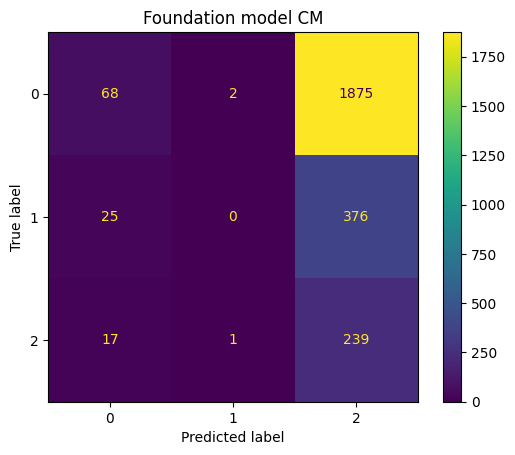

In [24]:
accuracy, f1, cm = eval_model(outputs_pretrained['true_labels'], outputs_pretrained['predicted_labels'])
print(f"Accuracy = {accuracy}, and F1-score = {f1}")
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Foundation model CM")
plt.savefig(os.path.join(output_dir, "Foundation model CM.png"))

Evaluation of the Foundation model resulted in accuracy of ~12%, and f1-score of ~0.1, which is very low. Moreover, as can be seen from the confusion matrix, 96% of the data is classified as label 1 (weak advice).

Loading the GPT2 Foundation Model, does not load the trained parameters of the final layer (score) and they are randomly initialised since the number of classes the model was trained and the number of classes in the current dataset are different.
This lowers the performance of the model.

## <a name="section_8"></a>**8. Performing Parameter-Efficient Fine-Tuning**


This section fine-tunes all linear leayers including Conv1D and Linear layers in GPT2

In [32]:
# Create Lora configutation
config_2 = LoraConfig(
    r=8, # lora attention dimension, aka rank
    lora_alpha=16, # W' = W + a*deltaW
    modules_to_save=["score"],
    lora_dropout=0.1, # dropout in the lora layer
)
# Reload Base model 
model.cpu()
del model
model = get_fm_model(tokenizer)
# Create PEFT MODEL
lora_model_2 = get_peft_model(model, config_2)
lora_model_2.to(device)
lora_model_2.print_trainable_parameters()



Loaidng LLM model..


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/peft/tuners/lora.py:475: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 299,520 || all params: 124,739,328 || trainable%: 0.2401167336736013


In [33]:
for name, param in lora_model_2.named_parameters():
    if param.requires_grad:
        print(name)

base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.1.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.1.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.2.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.2.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.3.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.3.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.4.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.4.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.5.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.5.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.6.attn.c_attn.lora_A.default.weight
base_model.model.transformer.h.6.attn.c_attn.lora_B.default.weight
base_model.model.transformer.h.7.attn.c_attn.lora_A.default.we

In [ ]:
## Apply PEFT
losses_hist_2 = training(lora_model_2, train_dataloader, class_weights=get_class_weight(train, device))
peft_model2_id = 'gpt2-loar-2'
lora_model_2.save_pretrained(peft_model2_id)

## Plot Fine-Tuning History

Text(0, 0.5, 'Loss')

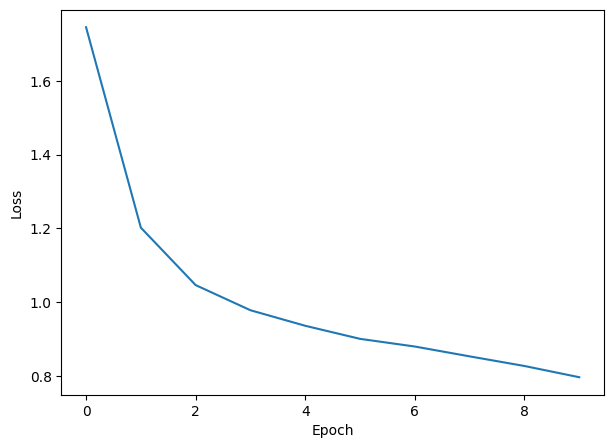

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(range(epochs), losses_hist_2[0])
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

In [36]:
outputs_lora_2 = evaluation(lora_model_2, test_dataloader, device)

Model evaluation:   0%|          | 0/868 [00:00<?, ?it/s]

Accuracy = 0.7791010372646946, and F1-score = 0.5415919997139111


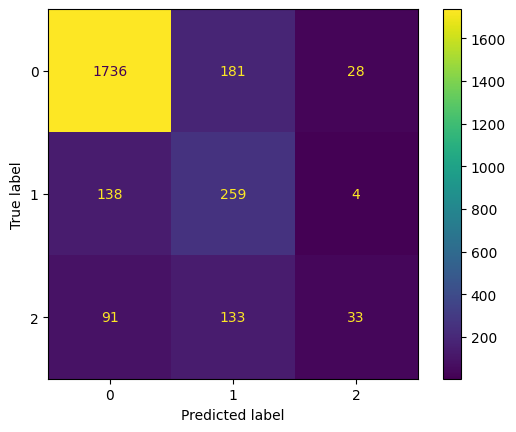

In [37]:
accuracy_peft, f1_peft, cm_peft = eval_model(outputs_lora_2['true_labels'], outputs_lora_2['predicted_labels'])
print(f"Accuracy = {accuracy_peft}, and F1-score = {f1_peft}")
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_peft)
disp.plot()
plt.savefig(os.path.join(output_dir, "peft_lora2.png"))

## <a name="section_9"></a>**9. Load and Perform Inference with a PEFT Model**

### Load model PEFT Model for inference

In [35]:
# Loading PEFT pretrained model
peft_model_id = 'gpt2-loar-2'
print("Loading PEFT pretrained model...")
# config = PeftConfig.from_pretrained(peft_model_id)
inference_model = AutoPeftModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path=peft_model_id,
    num_labels=num_labels
    )
# these are for GPT model: since we have custom padding token we need to initialise it for the model
# resize model embedding to match new tokenizer
inference_model.resize_token_embeddings(len(tokenizer))
# fix model padding token id
inference_model.config.pad_token_id = inference_model.config.eos_token_id
inference_model.to(device)
inference_model.eval()
print("Finised loading PEFT pretrained model!")

Loading PEFT pretrained model...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Finised loading PEFT pretrained model!


### Inference

In [36]:
## Apply PEFT
infer_result = evaluation(inference_model, test_dataloader, device)

Model evaluation:   0%|          | 0/868 [00:00<?, ?it/s]

In [97]:
# Updated test dataset with predicted labels from the foundation model
test = test.add_column('pred_label_lora2', outputs_lora_2['predicted_labels'].numpy().astype('int').tolist())
test.save_to_disk(os.path.join(output_dir, 'test'))

Saving the dataset (0/1 shards):   0%|          | 0/2603 [00:00<?, ? examples/s]

## <a name="section_10"></a>**10. Evaluate PEFT Model Pefrormance**
Model performance is evaluated as follows:
* Classification accuracy
* Classification F1-score
* Classification confusion matrix
* Mis-classified sequences have been also explored

Accuracy = 0.7791010372646946, and F1-score = 0.5415919997139111


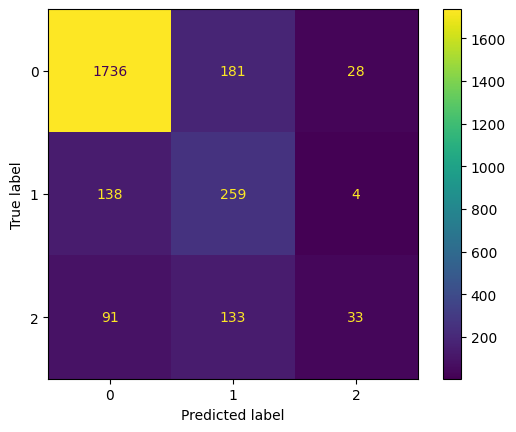

In [37]:
accuracy_peft, f1_peft, cm_peft = eval_model(infer_result['true_labels'], infer_result['predicted_labels'])
print(f"Accuracy = {accuracy_peft}, and F1-score = {f1_peft}")
# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_peft)
disp.plot()
plt.savefig(os.path.join(output_dir, "peft_lora2_loaded.png"))

**PEFT imporved model accuracy from from 12% to 78% and F1 improved from 0.1 to 0.54.**

### Explore mis-classfied entries

In [100]:
from datasets import load_dataset, load_from_disk
import os

In [101]:
# Load locally saved dataset which contains model output
ds = load_from_disk(os.path.join(output_dir, 'test'))
# Select only specific columns
ds = ds.select_columns(['output', 'input', 'labels', 'pred_label_lora2'])

In [106]:
def display_mis_classification(input_dataset, true_label, pred_label, num_entries=5):
    """
    Display examples of misclassified entries from a dataset.

    This function searches through a dataset to find and display a specified number of entries 
    where the true label matches `true_label` and the predicted label matches `pred_label`. 
    The function prints the input sequences for these misclassified examples.

    Args:
        input_dataset (datasets.Dataset): The dataset containing input sequences and their corresponding labels.
        true_label (int): The true label to search for in the dataset.
        pred_label (int): The predicted label to search for in the dataset.
        num_entries (int, optional): The number of misclassified examples to display. Defaults to 5.
    """
    # Initialize counters: n is the number of entries to display, i is the current dataset index
    n = num_entries
    i = 0

    # Loop through the dataset until either all rows are checked or the required number of examples is displayed
    while i < input_dataset.num_rows and n > 0:
        
        # Check if the true label and predicted label match the specified criteria
        if input_dataset[i]['labels'].item() == true_label and input_dataset[i]['pred_label_lora2'].item() == pred_label:
            # Print the input sequence for the misclassified example
            print(input_dataset[i]['input'] + "\n\n")
            # Decrement the counter for the number of examples left to display
            n -= 1
        
        # Move to the next row in the dataset
        i += 1


### Show sample 'No Advice' which are classified as 'Weak Advice"

In [107]:
display_mis_classification(ds, 0, 1, num_entries=5)

Adherence to a healthy diet may play a role in reducing the risk of extrahepatic BTC.


A larger and methodologically rigorous study is called for to further elucidate this finding and specifically determine the benefits of targeting EA with interventions such as ACT, in conjunction with evidence-based BFIs.


We determined it would be feasible to conduct a full-scale trial of a psychosocial intervention targeting adults with CHD, although with modifications to address practical barriers to participation.


This would provide impetus for the widespread adoption of 3D planning and IMRT.


The findings should be replicated in other intervention studies to further investigate glucose lowering effects and the opportunity to use bitter gourd for dietary self-management, especially in places where access to professional medical care is not easily assured.


This approach has the potential to improve cancer-screening rates significantly in settings that can provide telephone support to women 

### Show sample 'Weak Advice' which are classified as 'No Advice"

In [108]:
display_mis_classification(ds, 1, 0, num_entries=5)

Overall, these results suggest that lurasidone may be a useful treatment option for patients exhibiting agitation associated with acute psychotic symptoms of schizophrenia.


The findings showed that Cumulus can be used to measure density on all types of digital images.


The adapted FFQ is a reliable tool to estimate the dietary intake of energy, macronutrients, folate and vitamin B12 in women of reproductive age.


Results support the use of these theory-based strategies to reduce alcohol drinking in excess of guideline limits among undergraduates.


Although it is associated with a relatively high complication rate, patients with NTM lung disease whose disease is localized to one lung and who can tolerate resectional surgery might be considered for surgery, if there has been poor response to drug therapy or if the patients develop significant disease-related complications such as hemoptysis.


Overall, the findings of this study suggest that important gait and plantar pressure measu

### Show sample 'Strong advice' which are classified as 'weak advice"

In [109]:
display_mis_classification(ds, 2, 1, num_entries=5)

Based on our study we recommend the use of a short-arm radial gutter splint for initial immobilization of displaced distal radius fractures.


Solifenacin 5 mg is a recommended starting dose in Korean patients with OAB.


Use of the interlocked barbed polyglyconate suture technique prevents slippage, precluding the need for assistance, knot-tying and constant reassessment of anastomosis integrity.


Therefore this position should be used cautiously in higher-risk patients.


Reflecting the reality of clinical practice in resource limited settings, new diagnostics such as Xpert serve as important adjunctive tests but will not obviate the need for astute clinicians and comprehensive diagnostic algorithms.


Furthermore, stone loads greater than normally acceptable can be successfully undertaken in these patients, and should be attempted due to problems associated  with other techniques.




## <a name="section_11"></a>**11. Summary**

* Using PEFT, the sequence classification parformance as improved from F1-score from 0.01 to 0.54.
* LoRA PEFT was used
* Since there is huge class imbalace, class weighting was applied during PEFT.